# Introduction

In `main.ipynb` the goodfire API is called to collect experimental data into various CSVs. This code processes and plots that raw data into the IB/IH scatter plots seen in the presentation.

# Utilities

In [37]:
# @title IMPORTS
import pandas as pd
import numpy as np
import shared
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde
import seaborn as sns

# ignore depcrecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [38]:
# Clean and filter the data
def clean_df(df):
    if 'source' not in df.columns: df['source'] = 'OUS'
    if 'persona' not in df.columns: df['persona'] = ''
    if 'stddev_score' not in df.columns: df['stddev_score'] = 0
    df['persona'] = df['persona'].fillna('')
    df['feature'] = df['feature'].fillna('')
    df = df[(-0.8 < df['steerage']) & (df['steerage'] < 0.8)]
    return df

# Summarize the scores from the questions as two factors. 
# The Oxford Utilitarianism Scale has odd questions as coding for "Impartial Beneficence" and even as "Instrumental Harm",
# each of which is a simple average of responses.
def summarise_df(df):
    sources = df['source'].unique()
    questions = {
        source: shared.get_questions(source)
        for source in sources
    }

    df['factor'] = df.apply(lambda x: questions[x["source"]][x["question"]]["type"], axis=1)
    df2 = df[['feature', 'steerage', 'persona', 'factor', 'mean_score', 'stddev_score']].groupby(['feature', 'steerage', 'persona', 'factor'], as_index=False).mean()
    df2 = df2.pivot(index=['feature', 'steerage', 'persona'],columns='factor', values=['mean_score', 'stddev_score']).reset_index()
    df2["IB"] = df2[("mean_score", "IB")]
    df2["IH"] = df2[("mean_score", "IH")]
    df2["IB_stddev"] = df2[("stddev_score", "IB")]
    df2["IH_stddev"] = df2[("stddev_score", "IH")]
    df2.drop(columns=[("mean_score", "IB"), ("mean_score", "IH"), ("stddev_score", "IB"), ("stddev_score", "IH")], inplace=True)
    return df2

def get_df(*filenames, update=None):
    df = pd.concat([pd.read_csv(filename) for filename in filenames])
    if update:
        df = update(df)
    return summarise_df(clean_df(df))



In [39]:
# @title utilities for IH only / inverted IH questions

# check for duplicates in the IH scale questions
def check_IH_duplicate(df):

    def filter_and_renumber(group):
        if group['question'].nunique() > 39:
            # Step 2: Delete 2nd question (0 indexed => question 1)
            group = group[group['question'] != 1]
            
            # Step 3: Renumber the questions from 3-39 to 2-38
            def renumber_questions(subgroup):
                questions = subgroup['question'].values
                questions = [q-1 if q >=2 else q for q in questions]
                subgroup['question'] = questions
                return subgroup
            
            group = group.groupby('feature').apply(renumber_questions).reset_index(drop=True)
        return group

    df = df.groupby(['feature', 'source']).apply(filter_and_renumber).reset_index(drop=True)
    return df

# read csv and remocve duplicates if it is part of GGB_IHonly or GGB_invertedIH
def read_and_check_duplicate_csv(filename):
    df = check_IH_duplicate(pd.read_csv(filename))
    return df

def max_diff_by_feature(df):
    #score_range = df.groupby(['question', 'feature', 'persona', 'source'])['mean_score'].agg(
    score_range = df.groupby(['question', 'feature'])['mean_score'].agg(
        score_diff=lambda x: x.max() - x.min()
    ).reset_index()
    return score_range

# LOAD DATASETS

In [40]:
# @tile HUMAN DATASET
# Load and process the human dataset.
h1 = pd.read_csv("ous_data/ous_align2.csv")

h2 = h1.copy()
h2["IB"] = (h2["IB1"] + h2["IB2"] + h2["IB3"] + h2["IB4"] + h2["IB5"]) / 5
h2["IH"] = (h2["IH1"] + h2["IH2"] + h2["IH3"] + h2["IH4"]) / 4

human_df = h2
#h2 = h2[h2["country"]=="USA"]

#h2[["sex", "country", "age", "IB", "IH"]][:3]

In [41]:
# @title LOAD BASE MODELS 
def update(df):
    def get_short_base(base):
        return (base
                .replace("meta-llama/","")
                .replace("Meta-", "")
                .replace("Llama-", "")
                .replace("-Instruct", "")
        )
    df["feature"] = df.apply(lambda x: get_short_base(x["base"])  + " " + x["source"], axis=1)
    return df

base_df = get_df(
    "data/20241219172724_base70B_OUS.csv",
    "data/20241219173023_base70B_GGB.csv",
    "data/20241219173256_base8B_GGB.csv",
    "data/20241219173351_base8B_OUS.csv",
    "data/20241226183826_base70B33_OUS.csv",
    "data/20250125170346base70B33_GGB.csv",
    update=update)


In [42]:
# @title STEERING results for "moral"

# filenames
moral_33_ggb = "data/20250103153608_moral.csv"
moral_33 = 'data/20250114223758.csv'
moral_31 = "data/20241124001836.csv"


# load dataframe of 3.3 moral keywords (GGB)
moral_33_ggb_df = get_df(moral_33_ggb)

# load dataframe of 3.3 moral keywords results (OUS)
moral_33_df = get_df(moral_33)

# load dataframe of 3.1 moral keywords results(OUS)
moral_31_df = get_df(moral_31)


/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_6718/35264839.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['factor'] = df.apply(lambda x: questions[x["source"]][x["question"]]["type"], axis=1)


In [43]:
# @title STEERING results for multiple keywords on GGB (3.3 70B)
ggb_full_files = ['data/20250103153608_moral.csv', 
'data/20250117181646_altruism_updated.csv',
'data/20250103231956_greater good.csv', 
'data/20250104023112_ethic.csv', 
'data/20250104055843_integrity.csv', 
'data/20250104091128_dignity.csv']

# we're going to plot all of them in the same graph to make the point that IH is much harder to steer 
# than IB, and that the steering is consistent across different keywords
# small point - we didn't filter the features so going to make it a list of dataframes
ggb_max_score_ranges = [None]*len(ggb_full_files)
for i,f in enumerate(ggb_full_files):
    df = pd.read_csv(f)
    ggb_max_score_ranges[i]= max_diff_by_feature(clean_df(df))
    df = None

In [44]:
# @title  IH and inverted IH datasets (Base models)

full_GGB_file = 'data/20250125170346base70B33_GGB.csv'
GGB_inverted_file = 'data/20250119201457base70B33_GGB_inverted.csv'

# load dataframe for 3.3 base (GGB) and get rid of IB but keep IH questions
df_ggb = pd.read_csv(full_GGB_file)
df_base_IH = df_ggb[df_ggb['question'] <40].copy()
df_base_inverted = pd.read_csv(GGB_inverted_file)

In [45]:
# @title IH and inverted IH stering data
GGB_IH_only_files = [
    'data/GGB_IHonly20250121044426altruism.csv',
    'data/GGB_IHonly20250121123957empathy.csv',
    'data/GGB_IHonly20250121142449fairness.csv']

GGB_inverted_files = [
    'data/GGB_inverted20250121195539altruism.csv',
    'data/GGB_inverted20250121182226empathy.csv',
    'data/GGB_inverted20250121164933fairness.csv']

# list of dfs for IH only and inverted IH questions (max diff steering scores)
ggb_ih_only_max_scores = [max_diff_by_feature(clean_df(read_and_check_duplicate_csv(f))) for f in GGB_IH_only_files]   
ggb_ih_invert_max_scores = [max_diff_by_feature(clean_df(read_and_check_duplicate_csv(f)))for f in GGB_inverted_files]

# sanity check (number of unique questions and features)
print([df['question'].nunique() for df in ggb_ih_only_max_scores], [df['question'].nunique() for df in ggb_ih_invert_max_scores])
print([df['feature'].nunique() for df in ggb_ih_only_max_scores], [df['feature'].nunique() for df in ggb_ih_invert_max_scores])

[39, 39, 39] [39, 39, 39]
[10, 10, 10] [10, 10, 10]


In [46]:

def scatter_plot_feature(feature, persona, group, fontsize=15, use_legend=False, use_lines=True, error_bars=True):
    """Group should have IB/IH columns and be in sorted order"""
    # label the chart
    has_persona = persona
    has_feature = (group["steerage"] != 0).any()
    if has_persona and has_feature:
        name = f"{feature} ({persona})"
    elif has_persona:
        name = persona
    else:
        name = feature
    # Draw the actual dots
    if error_bars:
        sc = plt.errorbar(group['IB'], group['IH'], xerr=group["IB_stddev"], yerr=group["IH_stddev"],  marker='o',label=name)
        color = sc[0].get_color()
    else:
        sc = plt.scatter(group['IB'], group['IH'],  marker='o',label=name)
        color = sc.get_facecolor()
    # Connect the dots. These are draw as arrows so it's clear which end of series
    # is positive.
    if use_lines:
        for i in range(len(group) - 1):
            plt.annotate(
                '',  # No text for the annotation
                xy=(group['IB'].iloc[i + 1], group['IH'].iloc[i + 1]),  # Arrow end
                xytext=(group['IB'].iloc[i], group['IH'].iloc[i]),  # Arrow start
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color),  # Arrow style
            )

    if not use_legend:
        plt.text(group['IB'].iloc[-1] + 0.04, group['IH'].iloc[-1], name, fontsize=fontsize, ha='left', va='center')

def human_heatmap(human_df=h2):
    # Draw humans a heatmap
    ib_vals = np.arange(1, 8, 0.5)
    ih_vals = np.arange(1, 8, 0.5)
    heatmap, xedges, yedges = np.histogram2d(
        human_df['IB'], human_df['IH'], bins=(ib_vals, ih_vals)
    )
    plt.pcolormesh(xedges, yedges, heatmap.T, cmap='viridis', shading='auto', alpha=0.3)

def human_kde(human_df=h2, ax=None, alpha=1, colormap='Greys'):
    # TODO: Not sure this is correct?
    # Draw humans as KDE
    smoothness=20
    ib_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IB
    ih_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IH
    ib_grid, ih_grid = np.mgrid[1:7:(smoothness*1j), 1:7:(smoothness*1j)]
    positions = np.vstack([ib_grid.ravel(), ih_grid.ravel()])
    values = np.vstack([human_df['IB'], human_df['IH']])
    #values = np.vstack([np.random.random(10000) * 3, np.random.random(10000) * 5])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, ib_vals.shape + ih_vals.shape)
    if ax is None:
        plt.imshow(np.rot90(Z), cmap=colormap, extent=[1, 7, 1, 7], alpha=alpha)
    else:
        ax.imshow(np.rot90(Z), cmap=colormap, extent=[1, 7, 1, 7], alpha=alpha)

def make_plot(df2,
              is_subplot=False,
              heatmap=False,
              title='Feature steerage effect on Instrumental Harm and Impartial Beneficence', 
              fontsize=15,
              titlesize=20,
              use_legend=False,
              use_lines=True, human_df=h2):

    if not is_subplot:
         plt.figure(figsize=(10, 6))

    if heatmap:
        #human_heatmap(human_df=human_df)
        human_kde(human_df=human_df)

    for (feature, persona), group in df2.groupby(by=['feature', 'persona']):
        scatter_plot_feature(feature, persona, group, fontsize, use_legend, use_lines)

    # Add labels, legend, and grid
    # plt.xlim(1, 7)
    # plt.ylim(1, 7)
    # plt.xticks(range(1, 8))  # Tick marks from 1 to 7
    # plt.yticks(range(1, 8))  # Tick marks from 1 to 7
    plt.xlabel('Impartial Beneficence', fontsize=titlesize)
    plt.ylabel('Instrumental Harm', fontsize=titlesize)
    plt.title(title, fontsize=titlesize)
    if use_legend:
        plt.legend(loc="upper left")
    plt.grid(True)

    # Show plot
    if not is_subplot:
        plt.show()

def chunks(xs, n):
    n = max(1, n)
    return (xs[i:i+n] for i in range(0, len(xs), n))

def do_plots(df2, chunkby=5, *args, **kwargs):
    # TODO: Sort features by shape?
    all_features = df2["feature"].unique()
    for features in chunks(all_features, chunkby):
        make_plot(df2[df2["feature"].isin(features)], *args, **kwargs)

if False:
    baseline_df = get_df(baseline_models)
    h_mean = h2.agg(dict(IH='mean', IB='mean'))
    df = pd.DataFrame([dict(factor=0, feature='Human Mean', steerage=0, persona="", IB=h_mean['IB'], IH=h_mean['IH'])])
    df = pd.concat([df, baseline_df])
    print(df)
    make_plot(df, is_subplot=True, heatmap=True, title="Test")

In [47]:
def get_steepest(df,n=5, sortby="mag", coeff_range=0.1):
    # coeff_range is the range of steering coefficients to consider when looking at differences (e.g. 0.5 means consider the range -0.5 to 0.5)
    x = df.pivot(columns="steerage", index=["feature", "persona"])
    ib = (x[("IB", coeff_range)] - x[("IB", -coeff_range)]) / 0.2
    ih = (x[("IH", coeff_range)] - x[("IH", -coeff_range)]) / 0.2
    slope = pd.DataFrame({'IB': ib, 'IH': ih})
    slope["mag"] = (slope["IB"]**2+slope["IH"]**2)**0.5
    slope["IB"] = slope["IB"].abs()
    slope["IH"] = slope["IH"].abs()
    slope = slope.sort_values(sortby,ascending=False)
    best = slope[:n].reset_index()["feature"]
    return df[df["feature"].isin(best)]

In [48]:
def steering_lines(df_slice, name, ax):
    #lw = 3
    #sc = ax.errorbar(df_slice['IB'], df_slice['IH'], xerr=df_slice["IB_stddev"], yerr=df_slice["IH_stddev"],  marker='o', markersize=2 ,label=name)
    #color = sc[0].get_color()
    sc = ax.scatter(df_slice['IB'], df_slice['IH'], marker='o', s=2 ,label=name)
    color = sc.get_facecolor()
    for i in range(len(df_slice) - 1):
            ax.annotate(
                '',  # No text for the annotation
                xy=(df_slice['IB'].iloc[i + 1], df_slice['IH'].iloc[i + 1]),  # Arrow end
                xytext=(df_slice['IB'].iloc[i], df_slice['IH'].iloc[i]),  # Arrow start
                arrowprops=dict(arrowstyle='-|>', color=color,shrinkA=0, shrinkB=0)  # Arrow style
            )


# Charts

In [49]:
# @title PLOTTING PARAMETERS (defaults)

# Set the default font size for plots
text_size = 9
plt.rcParams.update({
    'font.size': text_size,        # Base font size
    'axes.titlesize': text_size,   # Title
    'axes.labelsize': text_size,   # Axis labels
    'xtick.labelsize': text_size,  # X tick labels
    'ytick.labelsize': text_size,  # Y tick labels
    'legend.fontsize': text_size,  # Legend
    'figure.titlesize': text_size,  # Figure title
    'lines.linewidth': 1.0,      # Line width
})
# Axis style (get rid of top and right)
plt.rcParams['axes.spines.top'] = False # remove the top line
plt.rcParams['axes.spines.right'] = False # remove the right line



Text(0.5, 1.0, 'Base Models vs Human Data (KDE)')

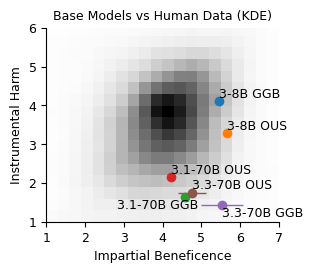

In [ ]:
# @title FIGURE 1 : base models v human data
fig, ax = plt.subplots(1,1)
fig.set_size_inches(3, 3, forward=False)


colors = plt.cm.Greys(np.linspace(0.01,1, 256))
custom_grey = LinearSegmentedColormap.from_list('custom_grey', colors)


human_kde(human_df=human_df, colormap=custom_grey)

for (base_model, _), group in base_df.groupby(by=['feature', 'persona']):
        # PLOT THE BASE MODEL DATA
        plt.errorbar(group['IB'], group['IH'], xerr=group["IB_stddev"], yerr=group["IH_stddev"],  marker='o',label=base_model)
        # ANNOTATE THE DATA POINTS
        x, y = group['IB'].values, group['IH'].values # get data point
        if base_model == '3.3-70B OUS':
               plt.annotate(base_model, (x, y + 0.1)) 
        elif base_model == '3.1-70B GGB':
                plt.annotate(base_model, (x - 1.75, y - 0.3))
        elif base_model == '3.3-70B GGB':
                plt.annotate(base_model, (x, y - 0.3))
        else:
                plt.annotate(base_model, (x, y + 0.1))
ax.set_ylim(1, 6)
plt.xlabel('Impartial Beneficence')
plt.ylabel('Instrumental Harm')
plt.title('Base Models vs Human Data (KDE)')


[Text(0, 1.0, ''),
 Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, ''),
 Text(0, 6.0, ''),
 Text(0, 7.0, '')]

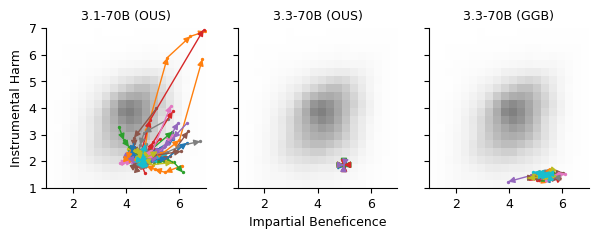

In [60]:
# @title Figure 2 : 3.1 steerability v 3.3 steerability

moral_31_feats = moral_31_df['feature'].unique()
moral_33_feats = moral_33_df['feature'].unique()
moral_33_ggb_feats = moral_33_ggb_df['feature'].unique()

fig, ax = plt.subplots(1,3)
fig.set_size_inches(7, 7/3, forward=False)

#ax[0] = plt.subplot(2, 1, 1)

human_kde(human_df=human_df, ax=ax[0], alpha=0.5)
for feature in moral_31_feats:
    df_slice = moral_31_df[moral_31_df['feature'] == feature]
    steering_lines(df_slice, feature, ax[0])

human_kde(human_df=human_df, ax=ax[1], alpha=0.5)
for feature in moral_33_feats:
    df_slice = moral_33_df[moral_33_df['feature'] == feature]
    steering_lines(df_slice, feature, ax[1])

human_kde(human_df=human_df, ax=ax[2], alpha=0.5)
for feature in moral_33_ggb_feats:
    df_slice = moral_33_ggb_df[moral_33_ggb_df['feature'] == feature]
    steering_lines(df_slice, feature, ax[2])


ax[0].title.set_text('3.1-70B (OUS)')
ax[1].title.set_text('3.3-70B (OUS)')
ax[2].title.set_text('3.3-70B (GGB)')

ax[1].set_xlabel('Impartial Beneficence')
ax[0].set_ylabel('Instrumental Harm')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

# for a in ax:
#     a.set_ylim(1, 7)
#     a.set_xlim(1, 7)
#make_plot(moral_31_df, is_subplot=True, heatmap=True, title="3.1 Steerability", use_legend=True, use_lines=False, human_df=h2)

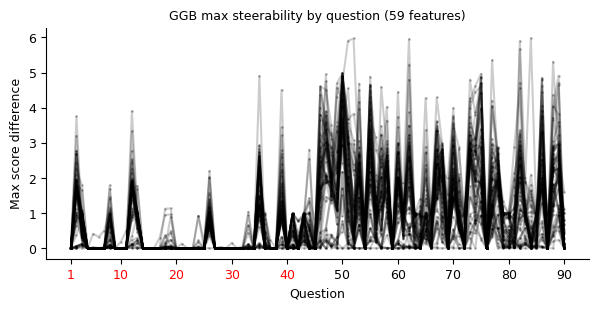

In [ ]:
# @title Figure 3 : 3.3 max steerability by question (GGB full)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,3, forward=False)
nfeats=0

for score_range in ggb_max_score_ranges:
    nfeats += (len(score_range['feature'].unique()))
    for feature in score_range['feature'].unique():
        mask = score_range['feature'] == feature
        plt.plot(score_range[mask]['question']+1, 
                    score_range[mask]['score_diff'],
                    marker='o',
                    markersize=1, linewidth=1.5,
                    label=feature, alpha=0.2, color='black')

plt.legend().remove() 
plt.xlabel('Question')
plt.ylabel('Max score difference')  
title_str = (f'GGB max steerability by question ({nfeats} features)')
plt.title(title_str)

# Get x-tick labels
q_ticks = np.arange(0,100,10)
q_ticks[0] =1
ax.set_xticks(q_ticks)
labels = ax.get_xticklabels()

# Color specific labels
for label in labels:
    if float(label.get_text())<= 40:
        label.set_color('red')
    else:
        label.set_color('black')


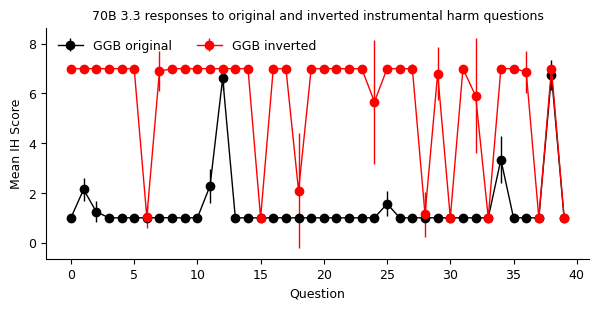

In [35]:
# Figure 4 : 3.3 GGH IH only vs inverted IH (base)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7, 3, forward=False)

# Plot the IH only data
ax.errorbar(df_base_IH['question'], df_base_IH['mean_score'],
                yerr=df_base_IH['stddev_score'],fmt='ko-', label='GGB original') 
ax.errorbar(df_base_inverted['question'], df_base_inverted['mean_score'],
                yerr=df_base_inverted['stddev_score'],fmt='ro-', label='GGB inverted') 
plt.grid(False)

plt.xlabel('Question')
plt.ylabel('Mean IH Score')
plt.title('70B 3.3 responses to original and inverted instrumental harm questions')
plt.legend(loc='upper left', bbox_to_anchor=None, frameon=False, ncol=2)



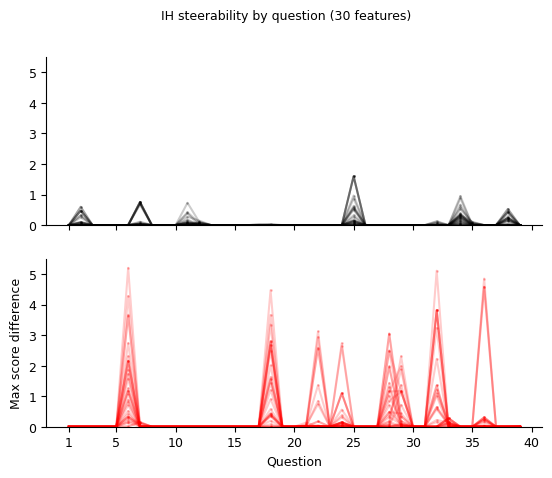

In [ ]:
# Figure 5 : 3.3 GGH IH only vs inverted IH (steerability)

fig, ax = plt.subplots(2,1)

# hard coded right now (see sanity check above)
nfeats=30

ax[0] = plt.subplot(2, 1, 1)
for score_range in ggb_ih_only_max_scores:
    for feature in score_range['feature'].unique():
        mask = score_range['feature'] == feature
        plt.plot(score_range[mask]['question']+1, 
                    score_range[mask]['score_diff'],
                    marker='o',
                    markersize=1, linewidth=1.5,
                    label=feature, alpha=0.2, color='black')

plt.legend().remove() 

ax[1] = plt.subplot(2, 1, 2)
for score_range in ggb_ih_invert_max_scores:
    for feature in score_range['feature'].unique():
        mask = score_range['feature'] == feature
        plt.plot(score_range[mask]['question']+1, 
                    score_range[mask]['score_diff'],
                    marker='o',
                    markersize=1, linewidth=1.5,
                    label=feature, alpha=0.2, color='red')

plt.legend().remove() 


plt.xlabel('Question')
plt.ylabel('Max score difference')  
title_str = (f'IH steerability by question ({nfeats} features)')
plt.suptitle(title_str)

# Get x-tick labels
q_ticks = np.arange(0,45,5)
q_ticks[0] =1
ax[0].set_ylim(0, 5.5)
#ax[0].set_yticks([0, 1, 2])
ax[1].set_ylim(0, 5.5)
ax[0].set_xticks(q_ticks)
ax[0].set_xticklabels([]) 
ax[1].set_xticks(q_ticks)

